Diagnostics for NR

In [1]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt

from measureEccentricity.measureEccentricity import get_available_methods
from measureEccentricity import measure_eccentricity
from measureEccentricity.load_data import load_waveform

%load_ext autoreload
%autoreload 2

/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


In [18]:
import glob

In [19]:
nr_waveforms = glob.glob("../data/ecc_waveforms/Non-Precessing/SXS/BBH_S*.h5")

In [43]:
waveform_path = nr_waveforms[7]
waveform_keywords = {"filepath": waveform_path,
                     "include_zero_ecc": True,
                    }
dataDict = load_waveform(catalog="LVCNR", **waveform_keywords)

/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/load_data.py:377: UserWarning: Too many tries to reset Momega0 for generating zeroecc modes. Total number of tries = 3
  " zeroecc modes. Total number of tries = "


In [44]:
dataDict["params_dict"]

{'q': 6.000588531804347,
 'chi1': [-4.4485048003033805e-11,
  -2.384286572958814e-11,
  -4.545174381160053e-08],
 'chi2': [1.8204081712243338e-12,
  2.6120685103327987e-12,
  -2.0390016169200095e-07],
 'ecc': 0.8,
 'mean_ano': 0.0,
 'deltaTOverM': 0.1000000000003638,
 'Momega0': 0.0011328270337400003}

(-12391.168408584588, 3817.8208339056127)

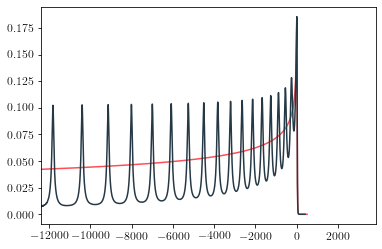

In [47]:
import numpy as np
plt.plot(dataDict["t_zeroecc"], np.abs(dataDict["hlm_zeroecc"][(2, 2)]))
plt.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]))
plt.xlim(dataDict["t"][0], )

Text(0.5, 0.98, 'method=ResidualAmplitude, ../data/ecc_waveforms/Non-Precessing/SXS/BBH_SHK_q6_e095_D65_Res3.h5')

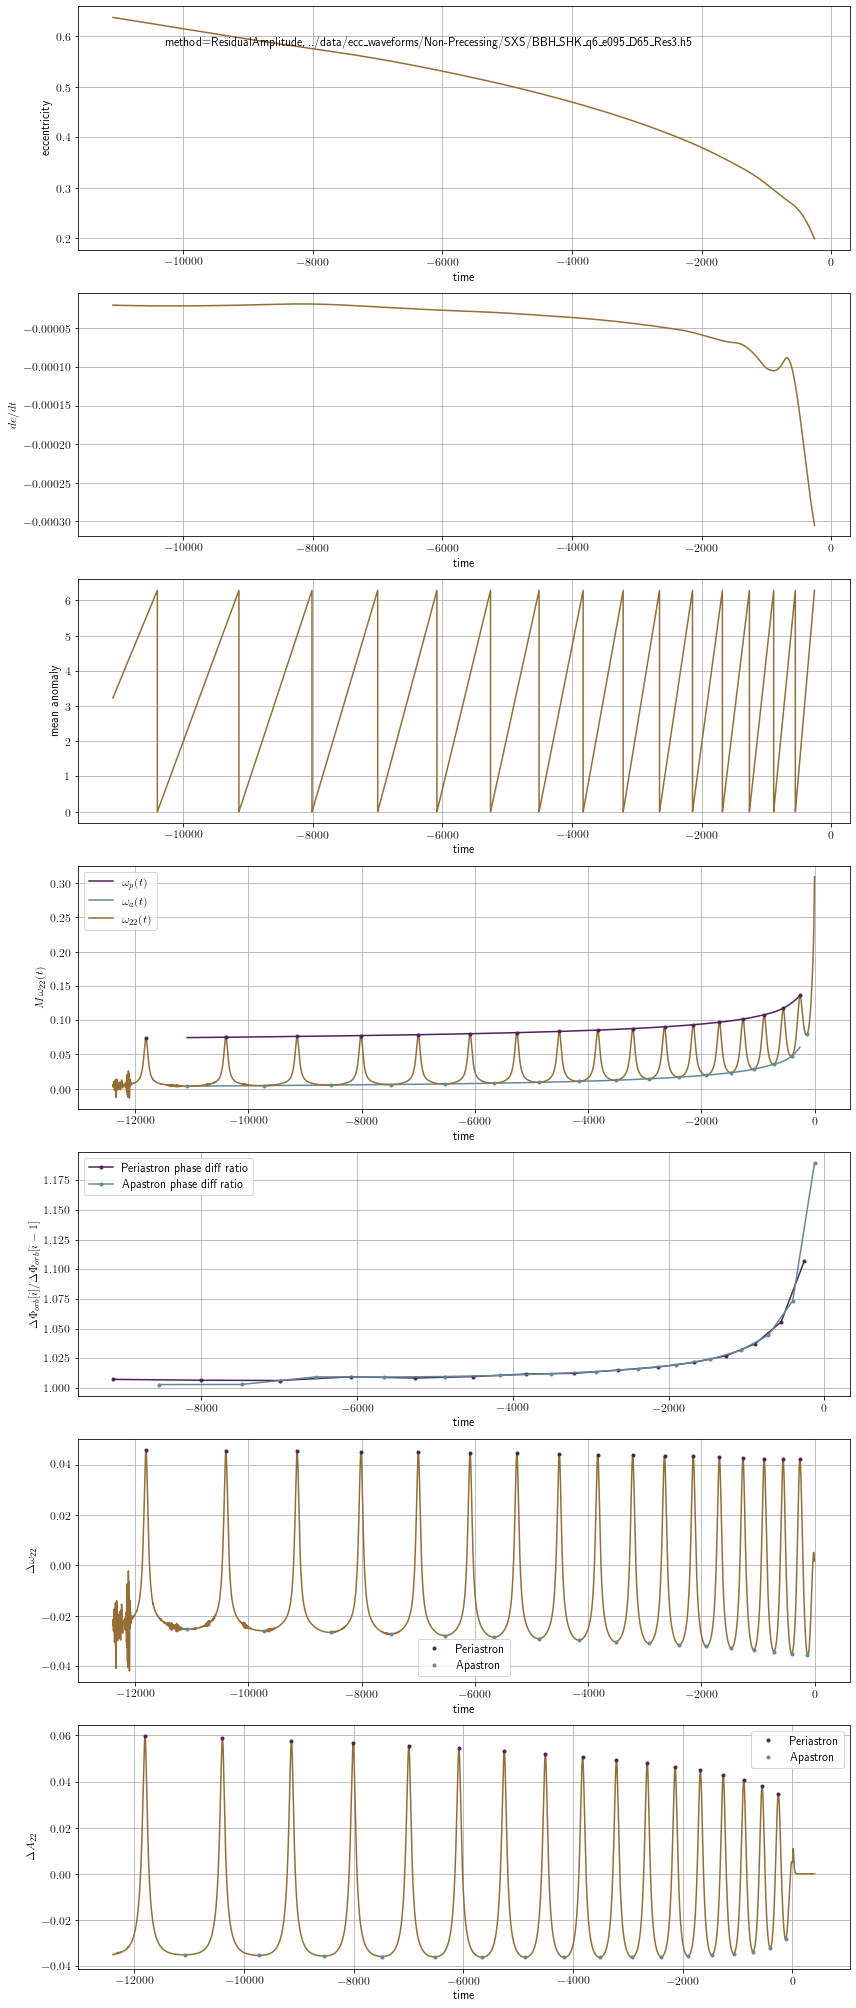

In [48]:
method = "ResidualAmplitude"
waveform_path = nr_waveforms[7]
tref_vec = dataDict["t"]
tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_in=tref_vec, dataDict=dataDict, method=method, 
                                                                return_ecc_method=True,
                                                                extra_kwargs={"debug": False})
fig, ax = eccMethod.make_diagnostic_plots()
fig.suptitle(f"method={method}, {waveform_path}")

### Diagnostic plots for Amplitude method

/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:421: UserWarning: Ecc(t) is non monotonic.
  warnings.warn("Ecc(t) is non monotonic.")


Text(0.5, 0.98, 'method=Amplitude, ../data/ecc_waveforms/Non-Precessing/SXS/BBH_SHK_q6_e095_D65_Res3.h5')

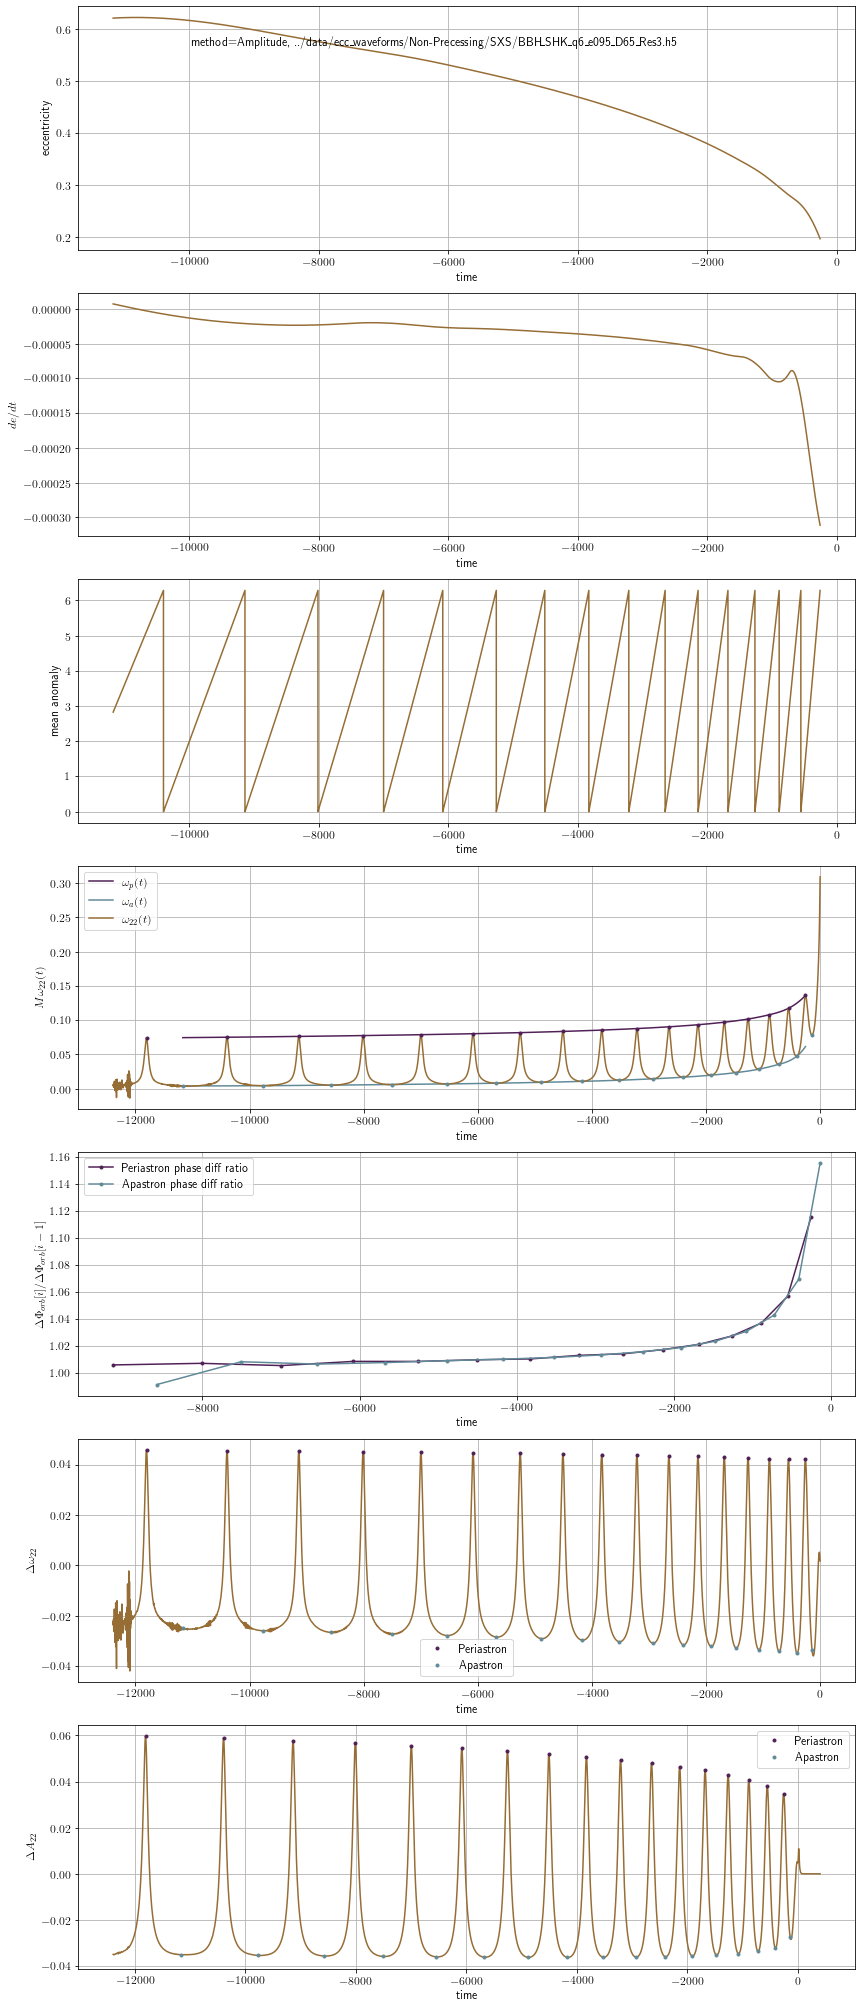

In [49]:
method = "Amplitude"
tref_vec = dataDict["t"]
tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_in=tref_vec, dataDict=dataDict, method=method, 
                                                                return_ecc_method=True,
                                                                extra_kwargs={"debug": False})
fig, ax = eccMethod.make_diagnostic_plots()
fig.suptitle(f"method={method}, {waveform_path}")

In [50]:
method = "FrequencyFits"
tref_vec = dataDict["t"]
tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_in=tref_vec, dataDict=dataDict, method=method, 
                                                                return_ecc_method=True,
                                                                extra_kwargs={"debug": False})
fig, ax = eccMethod.make_diagnostic_plots()
fig.suptitle(f"method={method}, {waveform_path}")

IndexError: index 5 is out of bounds for axis 0 with size 5

/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:421: UserWarning: Ecc(t) is non monotonic.
  warnings.warn("Ecc(t) is non monotonic.")


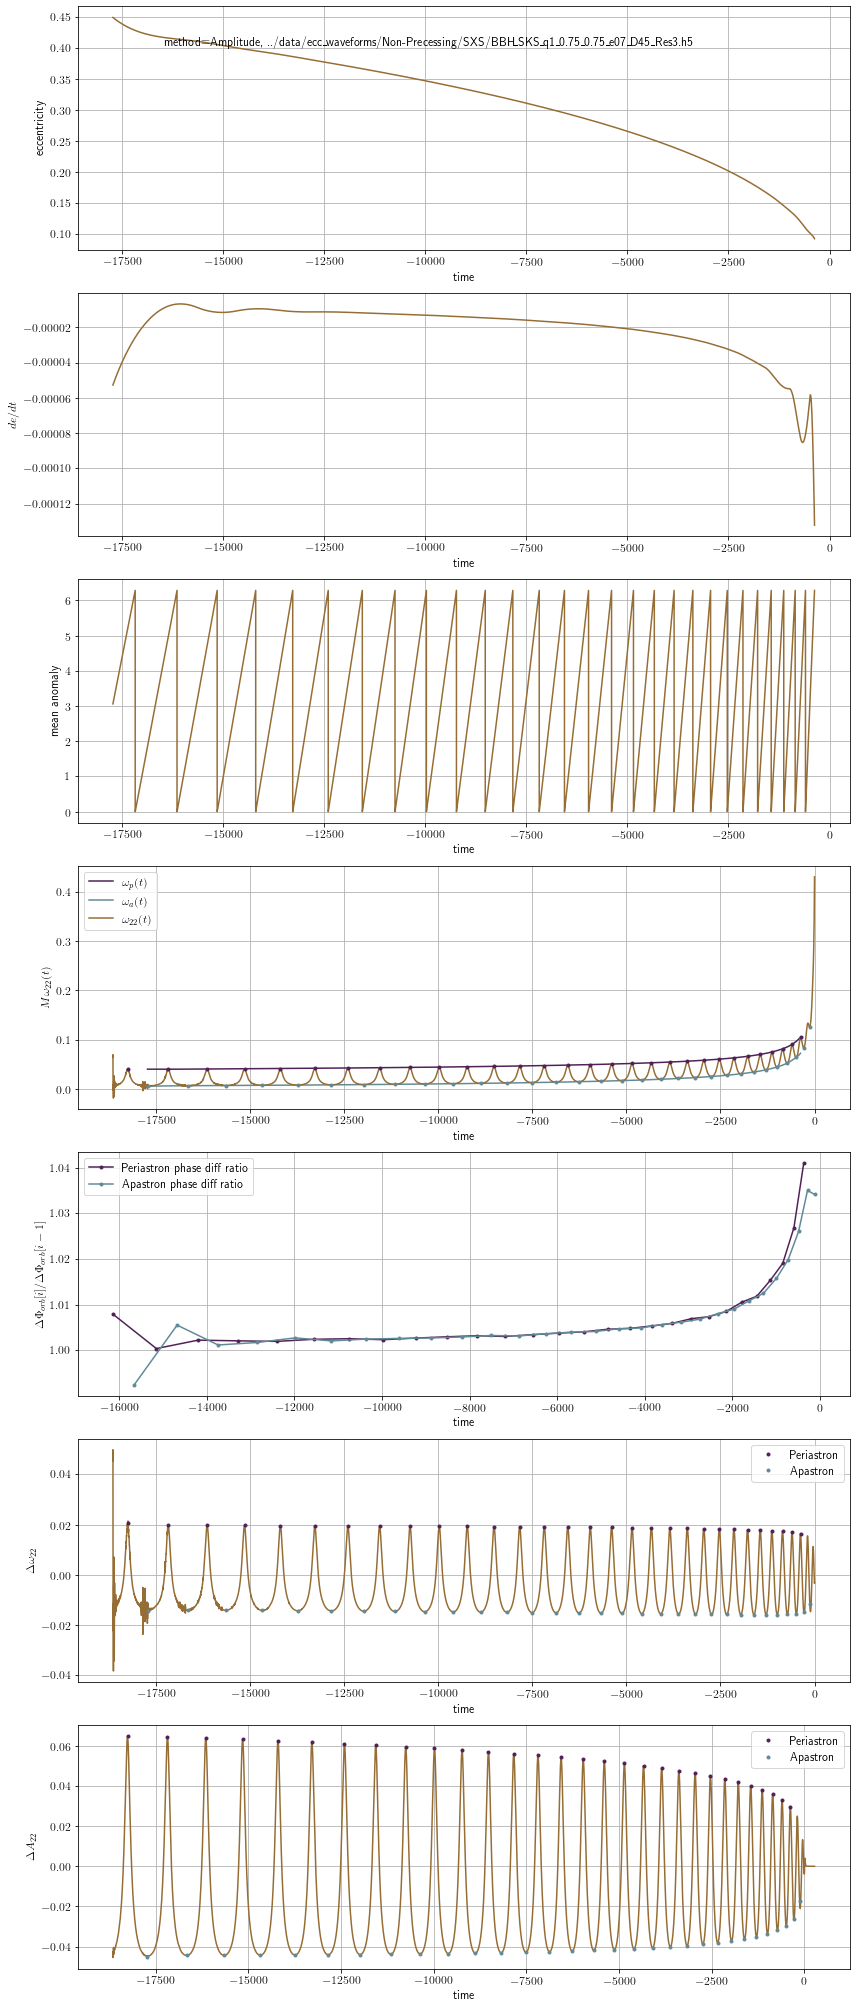

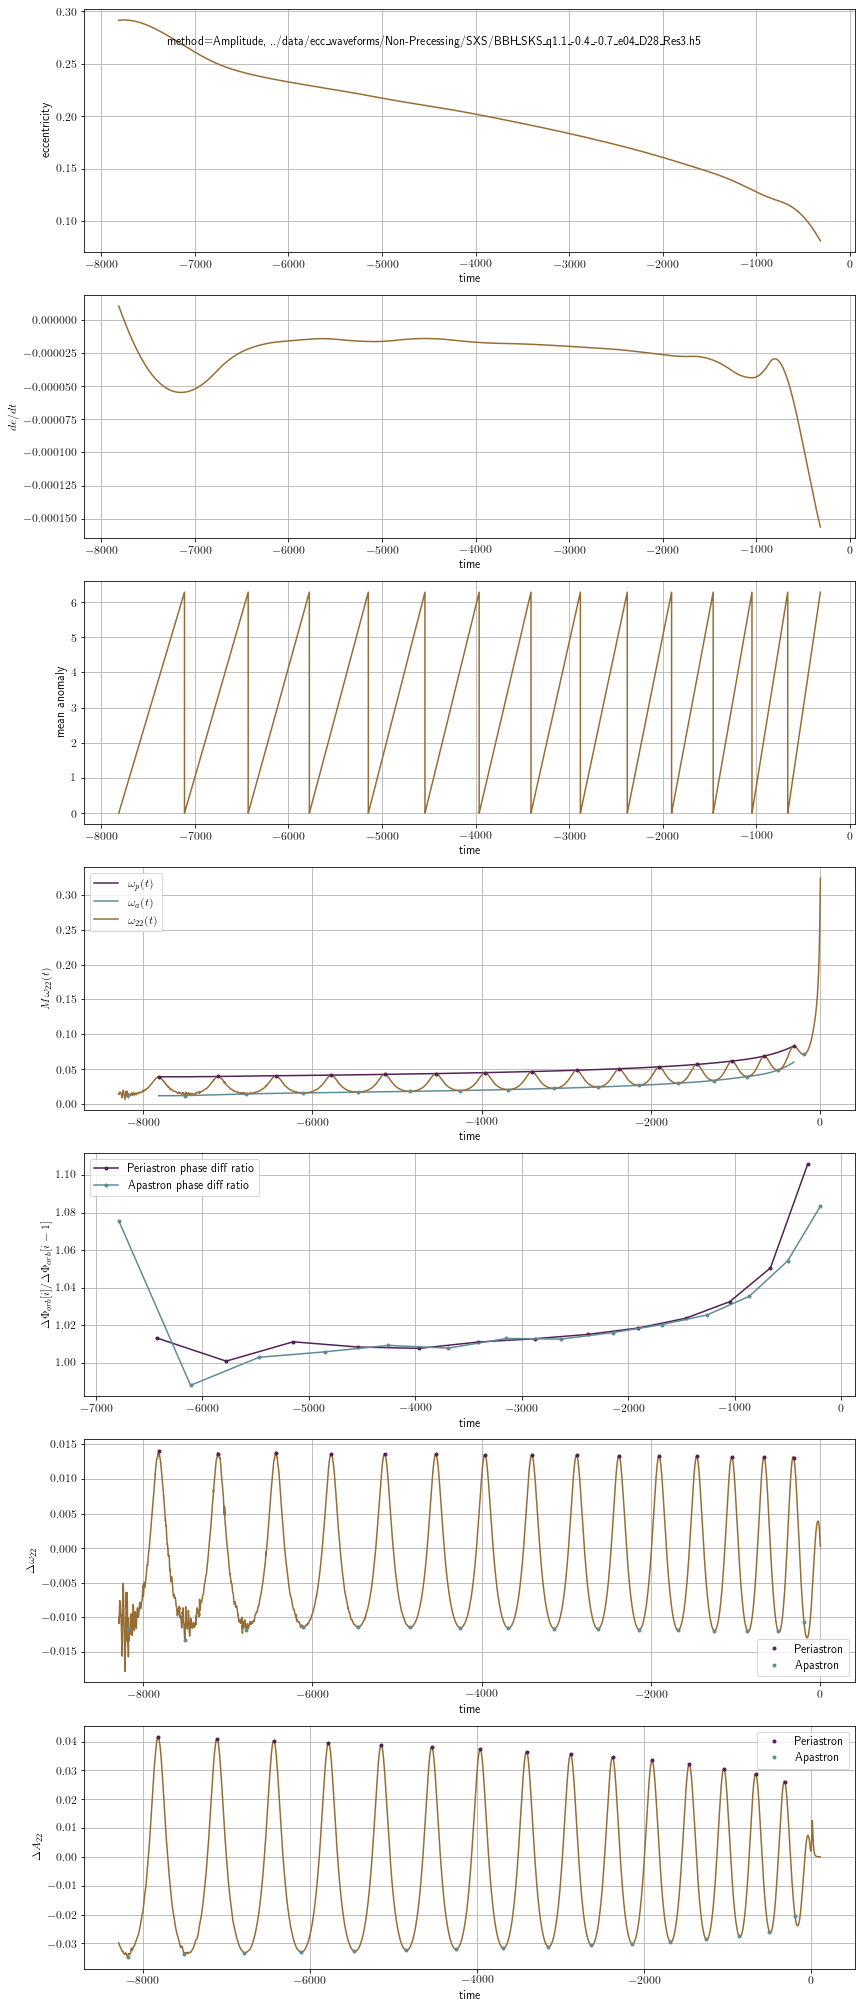

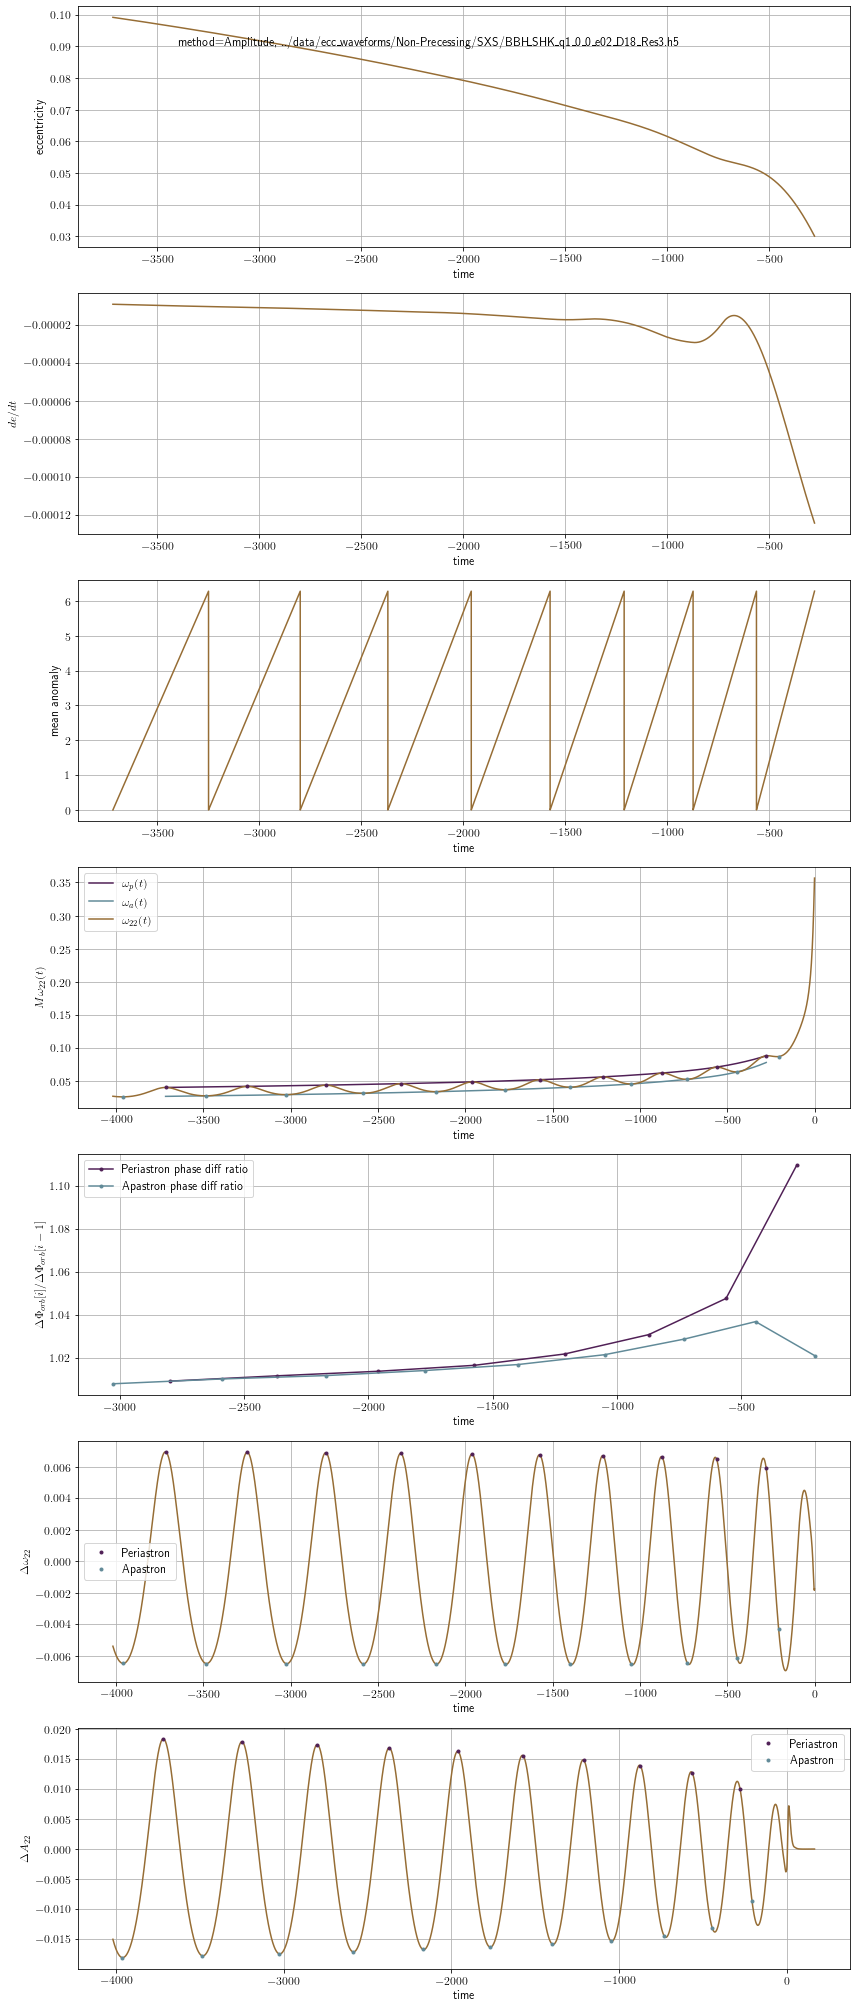

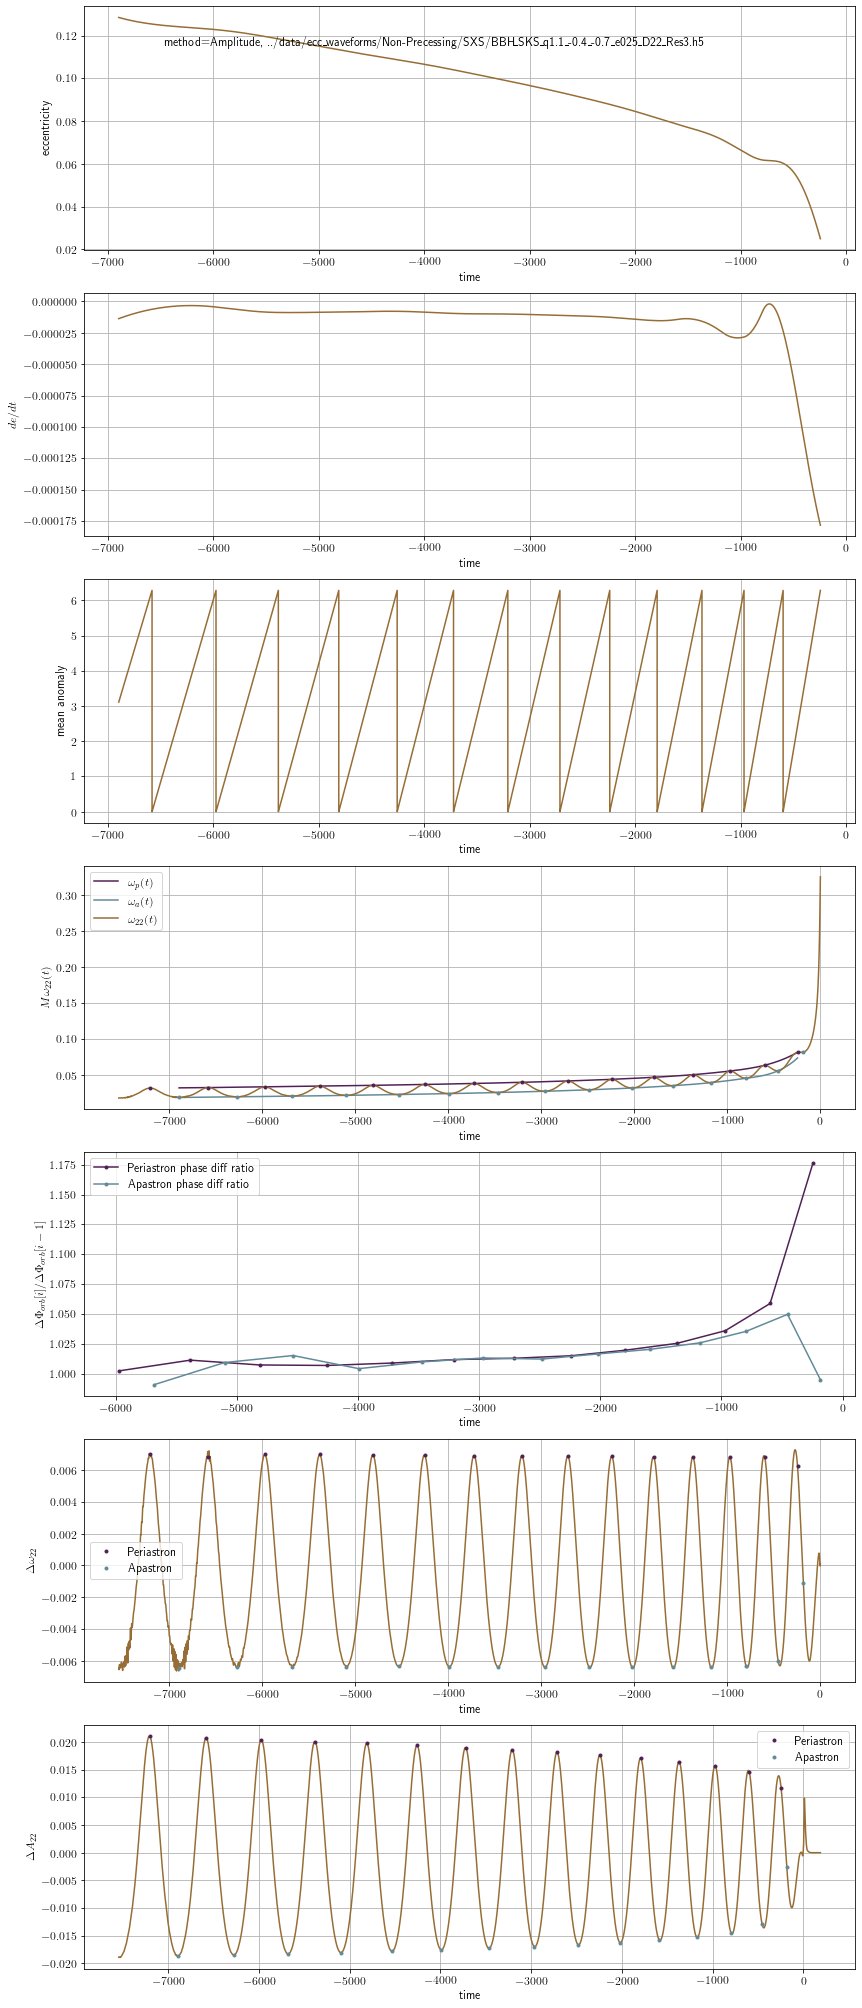

In [8]:
method = "Amplitude"
for waveform_path in nr_waveforms[1:5]:
    waveform_keywords = {"filepath": waveform_path,
                         #"include_zero_ecc": True
                        }
    dataDict = load_waveform(catalog="LVCNR", **waveform_keywords)
    tref_vec = dataDict["t"]
    tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_in=tref_vec, dataDict=dataDict, method=method, 
                                                                      return_ecc_method=True,
                                                                      extra_kwargs={"debug": False})
    fig, ax = eccMethod.make_diagnostic_plots()
    fig.suptitle(f"method={method}, {waveform_path}")

In [11]:
method = "FrequencyFits"
waveform_keywords = {"filepath": nr_waveforms[0],
                     "include_zero_ecc": True}
dataDict = load_waveform(catalog="LVCNR", **waveform_keywords)
tref_vec = dataDict["t"]
tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_in=tref_vec, dataDict=dataDict, method=method, 
                                                                return_ecc_method=True,
                                                                extra_kwargs={"debug": False})
fig, ax = eccMethod.make_diagnostic_plots()
fig.suptitle(f"method={method}, {waveform_path}")

IndexError: index 4 is out of bounds for axis 0 with size 4

Text(0.5, 0.98, 'method=Amplitude, ../data/ecc_waveforms/Non-Precessing/SXS/BBH_SKS_q1_0.75_0.75_e07_D45_Res3.h5')

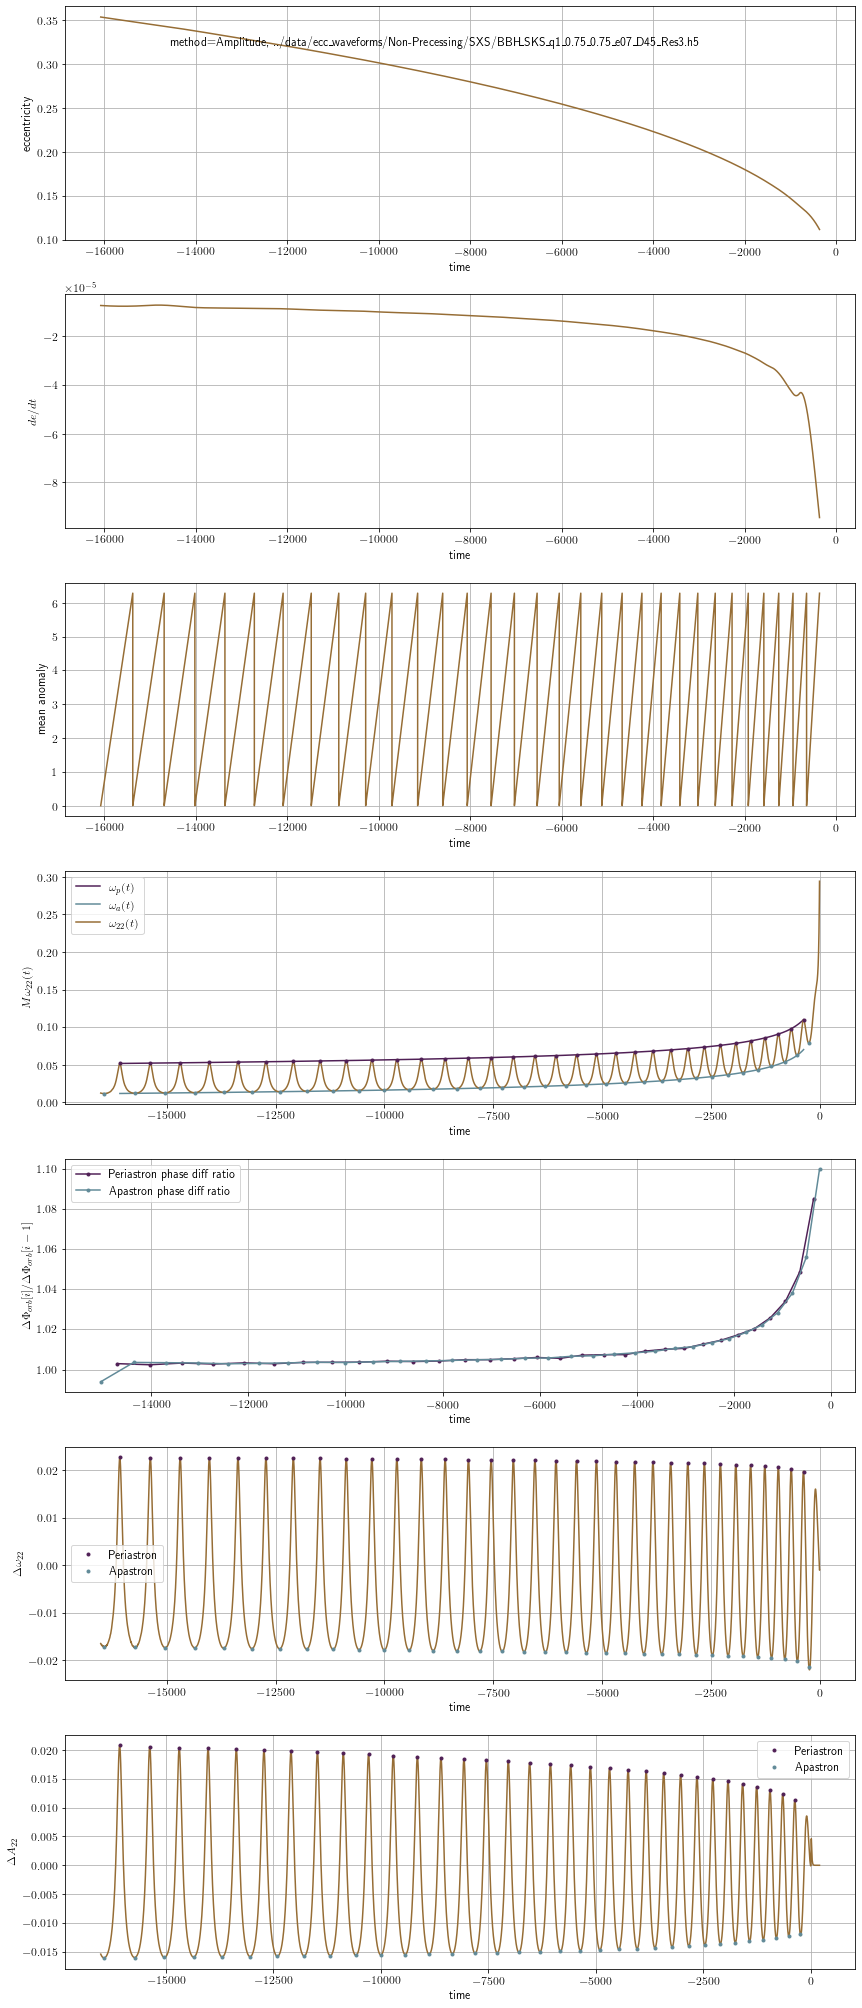

In [12]:
method = "Amplitude"
waveform_keywords = {"filepath": nr_waveforms[0],
                     #"include_zero_ecc": True
                    }
dataDict = load_waveform(catalog="LVCNR", **waveform_keywords)
tref_vec = dataDict["t"]
tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_in=tref_vec, dataDict=dataDict, method=method, 
                                                                return_ecc_method=True,
                                                                extra_kwargs={"debug": False})
fig, ax = eccMethod.make_diagnostic_plots()
fig.suptitle(f"method={method}, {waveform_path}")